In [3]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as md
import nglview as ng
from MDAnalysis.analysis.distances import distance_array
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

plt.style.use('seaborn-poster')
import warnings; warnings.simplefilter('ignore')

In [4]:
u0 = md.Universe('../Rama-Crystal-1/NPT/simfiles/init.gro')
u1 = md.Universe('../Rama-Crystal-1/NPT/simfiles/init.gro')
u2 = md.Universe('../Rama-Crystal-1/NPT/simfiles/solvate_genion.gro')

In [5]:
align.alignto(u0, u2, select="protein")

(3.0968893501280246e-05, 3.100638439502323e-05)

In [6]:
### name all water molecules as HOH in initial pdb

In [7]:
crystal_waters = u0.select_atoms('resname HOH and name OW')

### Extract all crystal water indices from the solvate_genion.gro using info from init.gro

In [9]:
#crystal_waters_atomgroup = u2.select_atoms('resname LLLLL')
box = u2.dimensions
d = distance_array(crystal_waters.positions, u2.select_atoms('resname SOL and name OW').positions, box=box, result=None, backend='OpenMP')
min_dist = np.min(d, axis=1)
non_crystal_indx = np.nonzero(min_dist > 0.1)
indices = np.argmin(d, axis=1)
crystal_indices = np.delete(indices, non_crystal_indx)
crystal_waters_atomgroup = u2.select_atoms('resname SOL and name OW').atoms[crystal_indices]




In [10]:
gromacs_universe = md.Universe('../Rama-Crystal-1/NPT/energyMinRun/em.tpr','../Rama-Crystal-1/NPT/simfiles/solvate_genion.gro' )

In [12]:
ng.show_mdanalysis(gromacs_universe)

NGLWidget()

In [13]:
#crystal_waters_atomgroup = u2.select_atoms('resname LLLLL')
box = gromacs_universe.dimensions
d = distance_array(crystal_waters.positions, gromacs_universe.select_atoms('resname SOL and name OW').positions, box=box, result=None, backend='OpenMP')
min_dist = np.min(d, axis=1)
non_crystal_indx = np.nonzero(min_dist > 0.1)
indices = np.argmin(d, axis=1)
crystal_indices = np.delete(indices, non_crystal_indx)
crystal_waters_atomgroup = gromacs_universe.select_atoms('resname SOL and name OW').atoms[crystal_indices]

### Create a gromacs .ndx file with all the crystal water indices: 

In [14]:
crystal_waters_atomgroup.write("crystal_waters.ndx", mode="w", name="crystal_waters")

1. Run:

gmx_mpi genrestr -f solvate_genion.gro -n crystal_waters.ndx -o posre_crystal_waters.itp

2. Add to the init.top:

#ifdef POSRES_CRYSTAL_WATER
#include "posre_crystal_waters.itp"
#endif

3. Use -DPOSRES_CRYSTAL_WATER in mdp file to run 



### Some of the crystal waters were not found in the genion_solvate structure. I do not care

In [110]:
for atom in u2.select_atoms('resname SOL and name OW')[non_crystal_indx]:
    print(atom)

<Atom 6005: OW of type O of resname SOL, resid 469 and segid SYSTEM>
<Atom 6041: OW of type O of resname SOL, resid 481 and segid SYSTEM>
<Atom 6464: OW of type O of resname SOL, resid 622 and segid SYSTEM>
<Atom 6584: OW of type O of resname SOL, resid 662 and segid SYSTEM>
<Atom 6905: OW of type O of resname SOL, resid 769 and segid SYSTEM>
<Atom 6926: OW of type O of resname SOL, resid 776 and segid SYSTEM>


### crystal_water_atomgroup is the AtomGroup where all crystal molecules are defined in solvate_genion

In [113]:
u_emin = md.Universe('../Rama-Crystal-1/NPT/simfiles/solvate_genion.gro','../Rama-Crystal-1/NPT/energyMinRun/confout.gro')

crystal_waters_selection = u_emin.select_atoms('resname HUI')
for atom in crystal_waters_atomgroup:
    crystal_waters_selection += u_emin.atoms[atom.index] 
print(crystal_waters_selection.n_atoms) 

370
(370, 3)


In [114]:
fixed_coordinates = crystal_waters_atomgroup.positions.copy()

## Approach number 2. 
### Here I do alignment of the structures and modify water coordinates so that there is no inconsistency

In [4]:
crystal_waters = u1.select_atoms('resname HOH and name OW')
crystal_coords = crystal_waters.positions.copy()

### check the size of the array:

In [5]:
crystal_coords.shape

(376, 3)

Playing around with alignment and rmsd analysis

In [8]:
u_berendsen = md.Universe('../Rama-Crystal-1/NPT/BerendsenRun/Berendsen.gro','../Rama-Crystal-1/NPT/BerendsenRun/traj_whole_nojump_center_compact.xtc')
protein_u1 = u1.select_atoms('protein')
protein_berendsen = u_berendsen.select_atoms('protein')

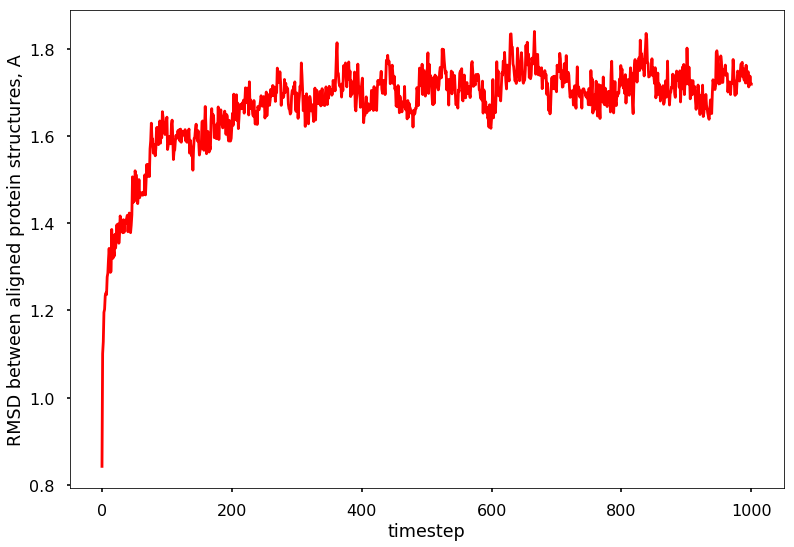

In [14]:
rmsds = []
for ts in u_berendsen.trajectory:
    rmsds.append(rmsd(protein_u1.positions, protein_berendsen.positions, superposition=True))
plt.plot(rmsds, 'r-')
plt.xlabel('timestep')
plt.ylabel('RMSD between aligned protein structures, A')
plt.show()

## Main analysis code:

Plots for cutoff = 1.0157894736842106


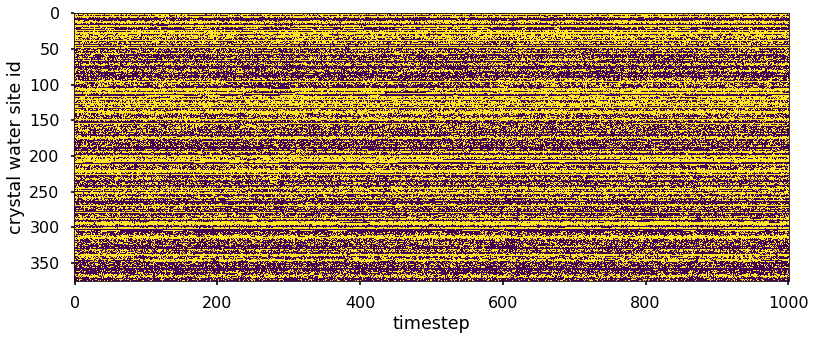

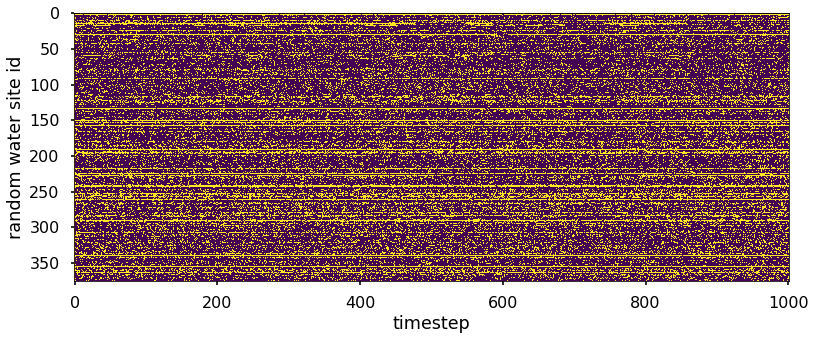

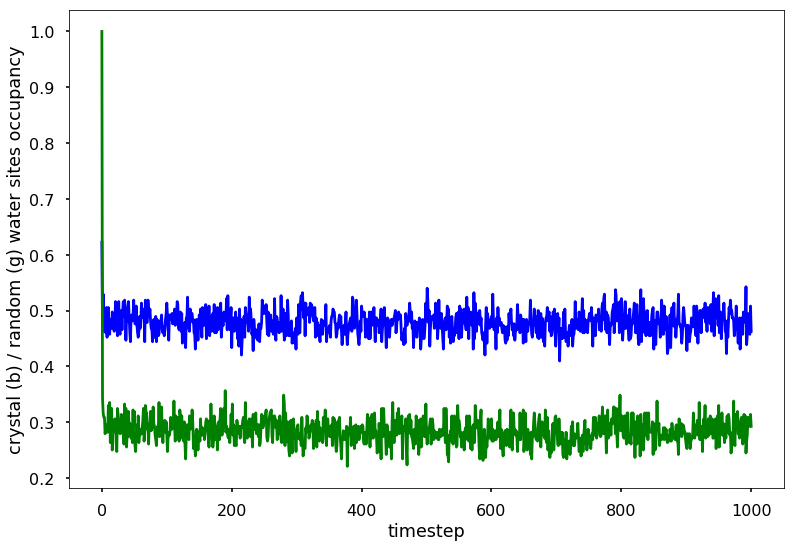

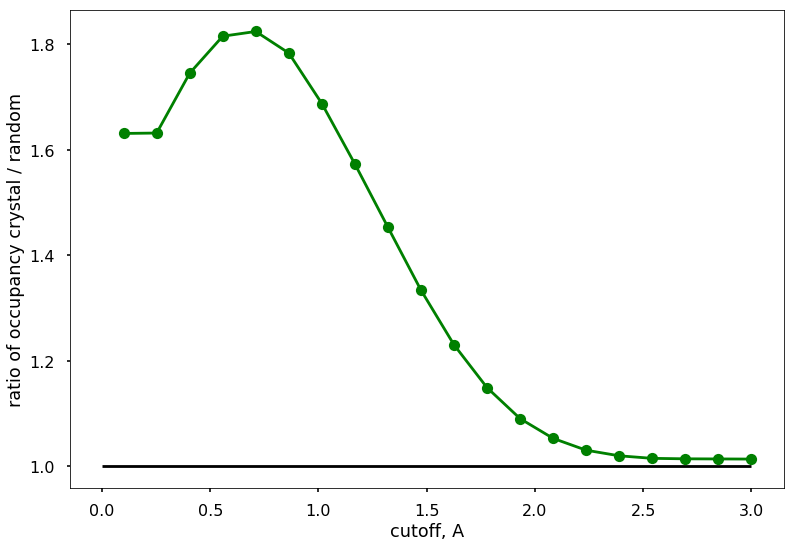

In [16]:
cutoffs = np.linspace(0.1, 3., num=20) # the range for cut off distances
percent_diff = []


u_berendsen = md.Universe('../Rama-Crystal-1/NPT/posResRun/firstframe.gro','../Rama-Crystal-1/NPT/posResRun/traj_whole_nojump_center_compact.xtc')
protein_berendsen = u_berendsen.select_atoms('protein')
oxygens = u_berendsen.select_atoms('resname SOL and name OW')

## choose random water oxygens and extract their positions at the first frame:
sample_oxygens = np.random.choice(oxygens.atoms.indices, size=376, replace=False )
random_waters_selection = u_berendsen.atoms[sample_oxygens]

assert random_waters_selection.n_atoms == 376, "The number of random sites is not 376!!!"
u_berendsen.trajectory[0]
fixed_random_coords = random_waters_selection.positions.copy()

for cutoff in cutoffs:
    print(cutoff)
    u0 = md.Universe('../Rama-Crystal-1/NPT/simfiles/init.gro')
    protein_u0 = u0.select_atoms('protein')
    crystal_waters0 = u0.select_atoms('resname HOH and name OW')
    
    u1 = md.Universe('../Rama-Crystal-1/NPT/simfiles/init.gro')
    protein_u1 = u1.select_atoms('protein')
    crystal_waters = u1.select_atoms('resname HOH and name OW')
    
    
    occupancy = np.zeros((1001, 376))
    random_occupancy = np.zeros((1001, 376))

    counter = 0
    for ts in u_berendsen.trajectory:

        mobile0 = protein_u0.positions - protein_u0.atoms.center_of_mass()
        ref0 = protein_berendsen.positions - protein_berendsen.atoms.center_of_mass()
        R, rmsd = align.rotation_matrix(mobile0, ref0)
        crystal_waters.positions = crystal_waters0.positions
        crystal_waters.atoms.translate(-protein_u0.atoms.center_of_mass())
        crystal_waters.atoms.rotate(R)
        crystal_waters.atoms.translate(protein_berendsen.atoms.center_of_mass())

        box = ts.dimensions
        d = distance_array(crystal_waters.positions, oxygens.positions, box=box, result=None, backend='OpenMP')
        mindist = np.min(d, axis=1)
        occupancy[counter] = mindist
        
        random_d = distance_array(fixed_random_coords, oxygens.positions, box=box, result=None, backend='OpenMP')
        random_mindist = np.min(random_d, axis=1)
        random_occupancy[counter] = random_mindist

        counter += 1 
    
    percent = np.sum(occupancy < cutoff, axis = 1) / 376.
    random_percent = np.sum(random_occupancy < cutoff, axis = 1) / 376.
    percent_diff.append(np.mean(percent[100:]) / np.mean(random_percent[100:]))
    
    if np.abs(cutoff - 1.0) < 0.1:
        
        print("Plots for cutoff = {}".format(cutoff))
        
        plt.imshow(occupancy.T < cutoff)
        plt.xlabel('timestep')
        plt.ylabel('crystal water site id')
        plt.show()

        plt.imshow(random_occupancy.T < cutoff)
        plt.xlabel('timestep')
        plt.ylabel('random water site id')
        plt.show()

        plt.plot(percent, 'b-', random_percent, 'g-')
        plt.xlabel('timestep')
        plt.ylabel('crystal (b) / random (g) water sites occupancy')
        plt.show()

plt.plot(cutoffs, percent_diff, 'go-')
plt.hlines(1.0, 0, 3.0)
plt.xlabel('cutoff, A')
plt.ylabel('ratio of occupancy crystal / random')
plt.show()